In [1]:
import sys
sys.path.append('../')
import dmg.model2graph.model2graph as m2g
import dmg.model2graph.metafilter as mf
from networkx.algorithms.isomorphism import is_isomorphic
import dmg.graphUtils as gu
import glob
from dmg.yakindu.yakinduPreprocess import removeLayout
import dmg.yakindu.yakinduPallete as yp
import random
random.seed(123)

# Load dataset

In [2]:
metafilter_refs = ['Region.vertices', 
                           'CompositeElement.regions',
                           'Vertex.outgoingTransitions',
                           'Vertex.incomingTransitions',
                           'Transition.target',
                           'Transition.source']
metafilter_cla = list(yp.dic_nodes_yak.keys())     
metafilter_atts = None
metafilterobj = mf.MetaFilter(references = metafilter_refs, 
                 attributes = metafilter_atts,
                 classes = metafilter_cla)       
meta_models = glob.glob("../data/metamodels/yakinduComplete/*")

In [3]:
%cd ..
files = glob.glob("data/yakinduDataset/train/*")
graphs = []
for f in files:
    graphs.append(m2g.model2graphJava('yakindu', f))
    #m2g.getGraphFromModel(f, 
                                  #meta_models, metafilterobj,
                                  #consider_atts = False)
%cd notebooks

/home/antolin/wakame/DMG-Python
/home/antolin/wakame/DMG-Python/notebooks


In [4]:
print('Number of graphs:', len(graphs))

Number of graphs: 203


In [5]:
%cd ..
files = glob.glob("data/yakinduDataset/val/*")
graphs_val = []
for f in files:
    #graphs_val.append(m2g.getGraphFromModel(f, 
    #                              meta_models, metafilterobj,
    #                              consider_atts = False))
    graphs_val.append(m2g.model2graphJava('yakindu', f))
%cd notebooks

/home/antolin/wakame/DMG-Python
/home/antolin/wakame/DMG-Python/notebooks


In [6]:
print('Number of graphs:', len(graphs_val))

Number of graphs: 51


In [7]:
yp.yakindu_pallete.shuffle = False

In [8]:
from torch_geometric.data import DataLoader
from dmg.deeplearning.dataGeneration import sequence2data, data2graph
from dmg.deeplearning.dataGeneration import addInvEdges

listDatas_val = []
batch_size = 64
max_len = 2
print('Preparing seqs')
for g in graphs_val:
    sequence = yp.yakindu_pallete.graphToSequence(g)
    sequence = [(addInvEdges(s[0], yp.yakindu_pallete, yp.yakindu_separator),s[1]) for s in sequence]
    listDatas_val = listDatas_val + sequence2data(sequence, yp.yakindu_pallete, max_len)
loader_val = DataLoader(listDatas_val, batch_size=batch_size, 
                        num_workers = 0, 
                        shuffle=False)
print('Seqs finished')

Preparing seqs
Seqs finished


In [9]:
do_eval = False

if not do_eval:
    graphs = graphs + graphs_val

In [10]:
print('Number of graphs:', len(graphs))

Number of graphs: 254


# Training

In [11]:
from dmg.deeplearning.generativeModel import GenerativeModel
from dmg.deeplearning.earlyStopping import EarlyStopping
import torch
import torch.nn as nn
import multiprocess as mp

def f(g):
    sequence = yp.yakindu_pallete.graphToSequence(g)
    sequence = [(addInvEdges(s[0], yp.yakindu_pallete, yp.yakindu_separator),s[1]) for s in sequence]
    return sequence2data(sequence, yp.yakindu_pallete, max_len)

epochs = 200
hidden_dim = 128


criterion_node = nn.CrossEntropyLoss(reduction = 'mean',ignore_index=-1)
criterion_action = nn.CrossEntropyLoss(reduction = 'mean')
criterion_finish = nn.BCELoss(reduction = 'mean')
model = GenerativeModel(hidden_dim, yp.dic_nodes_yak, yp.dic_edges_yak, yp.dic_operations_yak)
opt = torch.optim.Adam(model.parameters(), lr=0.001)
es = EarlyStopping(opt, model, 'yakinduGenerator.model', patience = 10)
#scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.1)

for epoch in range(epochs):
    model.train()
    total_loss = 0
    listDatas = []
    #preparing training set
    print('Preparing seqs')
    #for g in graphs:
    #    sequence = yp.yakindu_pallete.graphToSequence(g)
    #    listDatas = listDatas + sequence2data(sequence, yp.yakindu_pallete, max_len)
    with mp.Pool(10) as pool:
        listDatas = pool.map(f, graphs)
    listDatas = [r for rr in listDatas for r in rr]
    print('Seqs finished')
    loader = DataLoader(listDatas, batch_size=batch_size, 
                            num_workers = 0, 
                            shuffle=False)
    #training
    for data in loader:
        opt.zero_grad()
        action, nodes, finish = model(data.x, data.edge_index, 
                        torch.squeeze(data.edge_attr,dim=1), 
                data.batch, data.sequence, data.nodes, data.len_seq, data.action)
        
        nodes = torch.unsqueeze(nodes, dim = 2).repeat(1,1,2)
        nodes[:,:,0] = 1 - nodes[:,:,1]
            
        L = torch.max(data.len_seq).item()
        gTruth = data.sequence_masked[:,0:L]
        loss = (criterion_node(nodes.reshape(-1,2), gTruth.flatten()) +
                    criterion_action(action, data.action) +
                    criterion_finish(finish.flatten(), data.finished.float())) / 3
        total_loss += loss.item()
        loss.backward()
        opt.step()
    #validation
    if do_eval:
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data in loader_val:
                action, nodes, finish = model(data.x, data.edge_index, 
                            torch.squeeze(data.edge_attr,dim=1), 
                    data.batch, data.sequence, data.nodes, data.len_seq, data.action)
                nodes = torch.unsqueeze(nodes, dim = 2).repeat(1,1,2)
                nodes[:,:,0] = 1 - nodes[:,:,1]

                L = torch.max(data.len_seq).item()
                gTruth = data.sequence_masked[:,0:L]
                loss = (criterion_node(nodes.reshape(-1,2), gTruth.flatten()) +
                        criterion_action(action, data.action) +
                        criterion_finish(finish.flatten(), data.finished.float())) / 3
                val_loss+= loss.item()
        
    print('Epoch',epoch,'Loss Traning',total_loss/(len(loader)))
    #scheduler.step()
    if do_eval:
        print('Epoch',epoch,'Loss Val',val_loss/(len(loader_val)))
    
    if do_eval:
        if es.step(val_loss/(len(loader_val)), epoch):
            break
    else:
        if es.step(total_loss/(len(loader)), epoch):
            break
        

Preparing seqs
Seqs finished


/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 Loss Traning 0.6505785439465497
Preparing seqs
Seqs finished
Epoch 1 Loss Traning 0.5191966730195123
Preparing seqs
Seqs finished
Epoch 2 Loss Traning 0.480649112044154
Preparing seqs
Seqs finished
Epoch 3 Loss Traning 0.46743085174947174
Preparing seqs
Seqs finished
Epoch 4 Loss Traning 0.46311659104115255
Preparing seqs
Seqs finished
Epoch 5 Loss Traning 0.4641547541360597
Preparing seqs
Seqs finished
Epoch 6 Loss Traning 0.45345229554820704
Preparing seqs
Seqs finished
Epoch 7 Loss Traning 0.44804251999468414
Preparing seqs
Seqs finished
Epoch 8 Loss Traning 0.4483869679876276
Preparing seqs
Seqs finished
Epoch 9 Loss Traning 0.44556039813402537
Preparing seqs
Seqs finished
Epoch 10 Loss Traning 0.43486406915896647
Preparing seqs
Seqs finished
Epoch 11 Loss Traning 0.44132121833595067
Preparing seqs
Seqs finished
Epoch 12 Loss Traning 0.4360272634673763
Preparing seqs
Seqs finished
Epoch 13 Loss Traning 0.43215653944659876
Preparing seqs
Seqs finished
Epoch 14 Loss Traning 0

# Loading test

In [12]:
%cd ..
files = glob.glob("data/yakinduDataset/test/*")
graphs_test = []
for f in files:
    #graphs_test.append(m2g.getGraphFromModel(f, 
    #                              meta_models, metafilterobj,
    #                              consider_atts = False))
    graphs_test.append(m2g.model2graphJava('yakindu', f))
%cd notebooks

/home/antolin/wakame/DMG-Python
/home/antolin/wakame/DMG-Python/notebooks


# Sample models

In [13]:
from dmg.deeplearning.generativeModel import sampleGraph

model.eval()
samples = [sampleGraph(yp.G_initial_yak, yp.yakindu_pallete, model, 50, yp.yakindu_separator) 
           for i in range(1000)]

../dmg/deeplearning/generativeModel.py:133: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  m = Categorical(F.softmax(torch.squeeze(action)))
/home/antolin/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


# Visual comparison

## Size

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


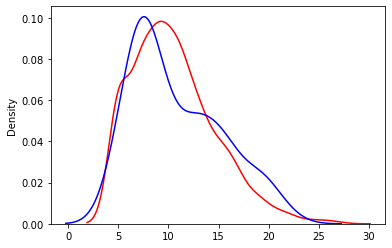

In [14]:
import seaborn as sns

sns.distplot([len(G) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

## Degree

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


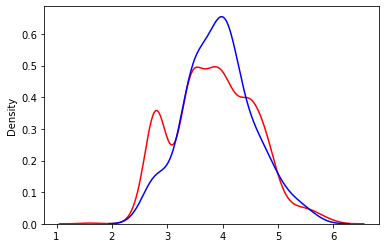

In [15]:
import numpy as np
import dmg.realism.metrics as mt
sns.distplot([np.mean(mt.getListDegree(G)) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

## MPC

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


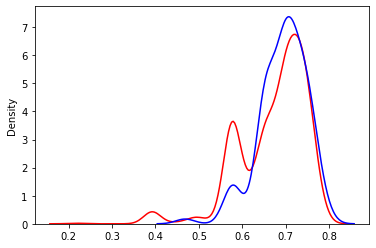

In [16]:
dims = list(yp.dic_edges_yak.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

# Node activity

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


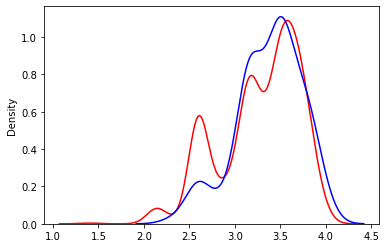

In [17]:
dims = list(yp.dic_edges_yak.keys())
sns.distplot([np.mean(list(mt.nodeActivity(G,dims))) for G in samples], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.nodeActivity(G,dims))) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

# Check isomorf and consistency

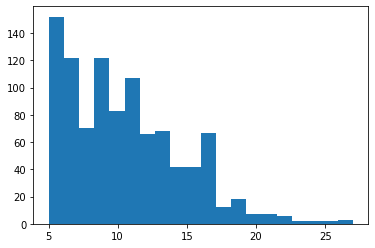

In [18]:
import matplotlib.pyplot as plt

h = plt.hist([len(G) for G in samples], bins = 20)

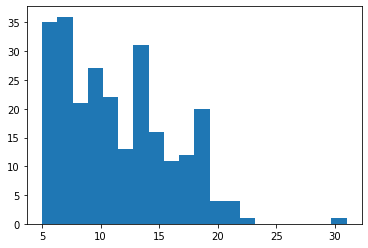

In [19]:
h = plt.hist([len(G) for G in graphs], bins = 20)

In [20]:
#check isomorf
iso = []
for s in samples:
    for g in graphs:
        if (is_isomorphic(s,g,gu.node_match_type, gu.edge_match_type)):
            iso.append(s)
            break
print(len(iso)*100/len(samples),'% iso')
not_iso = [g for g in samples if not g in iso]

40.5 % iso


Mean size: 7.4222222222222225


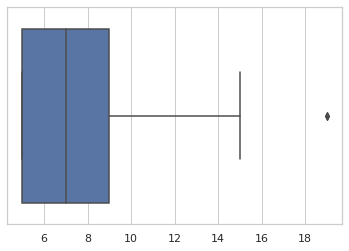

In [21]:
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=[len(G) for G in iso])
print('Mean size:', np.mean([len(G) for G in iso]))

In [22]:
from dmg.yakindu.yakinduConsistency import inconsistent
#check consistency
inconsistents = []
for s in samples:
    if inconsistent(s):
        inconsistents.append(s)
print(len(inconsistents)*100/len(samples),'% inconsistents')
not_inconsistents = [g for g in samples if not g in inconsistents]

13.4 % inconsistents


Mean size: 12.783582089552239


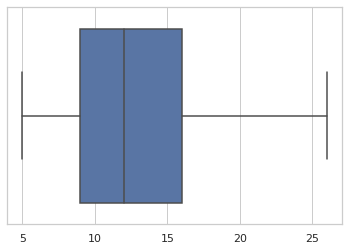

In [23]:
ax = sns.boxplot(x=[len(G) for G in inconsistents])
print('Mean size:', np.mean([len(G) for G in inconsistents]))

In [24]:
clean_new_models = [g for g in not_iso if not g in inconsistents]

Mean size: 12.470967741935484


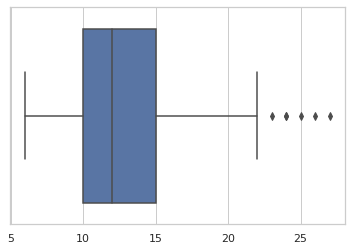

In [25]:
ax = sns.boxplot(x=[len(G) for G in clean_new_models])
print('Mean size:', np.mean([len(G) for G in clean_new_models]))

Mean size: 11.311023622047244


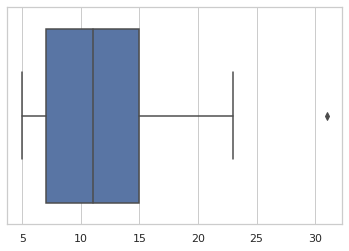

In [26]:
ax = sns.boxplot(x=[len(G) for G in graphs])
print('Mean size:', np.mean([len(G) for G in graphs]))

In [27]:
print(len(clean_new_models),'clean models')
print(len(clean_new_models)*100/len(samples),'% clean models')

465 clean models
46.5 % clean models


# Clean models

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


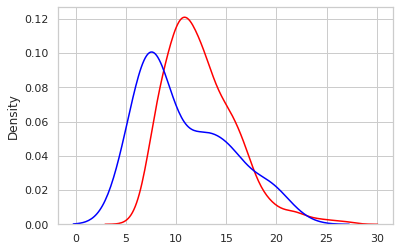

In [28]:
import seaborn as sns

sns.distplot([len(G) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


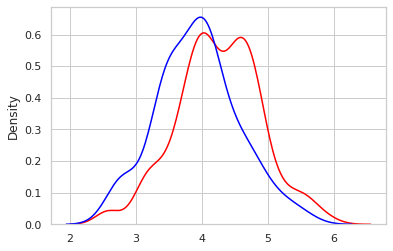

In [29]:
sns.distplot([np.mean(mt.getListDegree(G)) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


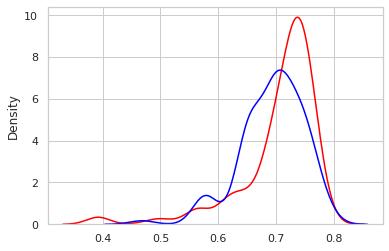

In [30]:
dims = list(yp.dic_edges_yak.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in clean_new_models], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

# Consistent models

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


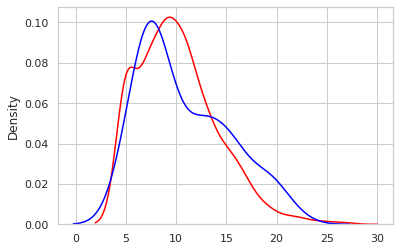

In [31]:
import seaborn as sns

sns.distplot([len(G) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([len(G) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


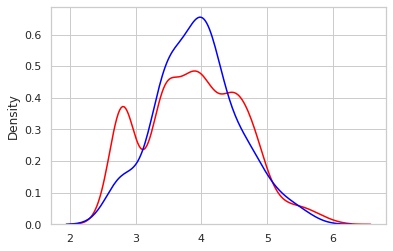

In [32]:
sns.distplot([np.mean(mt.getListDegree(G)) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(mt.getListDegree(G)) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/antolin/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


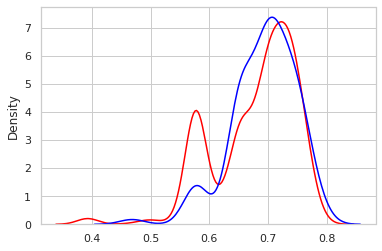

In [33]:
dims = list(yp.dic_edges_yak.keys())
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in not_inconsistents], hist=False, kde=True, 
             bins=int(180/5), color = 'red', label = 'NN')
sns.distplot([np.mean(list(mt.MPC(G,dims).values())) for G in graphs_test], hist=False, kde=True, 
             bins=int(180/5), color = 'blue', label = 'Real')

In [34]:
def uniques(Gs):
    dic = set([])
    for G1 in Gs:
        iso = False
        for G2 in dic:
            if is_isomorphic(G1, G2, gu.node_match_type, gu.edge_match_type):
                iso = True
        if not iso:
            dic.add(G1)
    return dic

In [35]:
print(len(not_inconsistents)/len(samples) * 100, '% Validity among all')
print(len(uniques(not_inconsistents))/len(not_inconsistents) * 100, '% Uniqueness among valid ones')
print(len(uniques(clean_new_models))/len(uniques(samples)) * 100, '% Novelty among unique ones')

86.6 % Validity among all
43.418013856812934 % Uniqueness among valid ones
70.69672131147541 % Novelty among unique ones


# Realism using GNN

In [44]:
from torch_geometric.data import Data
from dmg.deeplearning.dataGeneration import generateTensorsFromGraph
syns = []
sett = clean_new_models#samples#clean_new_models#not_inconsistents
for G in random.sample(sett,min(len(sett),len(graphs_test))):
    G_inv = addInvEdges(G, yp.yakindu_pallete, yp.yakindu_separator)
    tensors = generateTensorsFromGraph(G_inv, yp.yakindu_pallete, 2, 2)
    data =  Data(x = tensors[0],
                edge_index = tensors[-2], 
                edge_attr = tensors[-1],
                y = torch.tensor(0))
    syns.append(data)

In [45]:
reals = []
for G in random.sample(graphs_test,min(len(sett),len(graphs_test))):
    G_inv = addInvEdges(G, yp.yakindu_pallete, yp.yakindu_separator)
    tensors = generateTensorsFromGraph(G_inv, yp.yakindu_pallete, 2, 2)
    data =  Data(x = tensors[0],
                edge_index = tensors[-2], 
                edge_attr = tensors[-1],
                y = torch.tensor(1))
    reals.append(data)

In [46]:
dataset = syns + reals
random.shuffle(dataset)
print('Len train:', len(dataset))

Len train: 220


In [47]:
from torch.utils.data import random_split
import torch
train_len = int(0.8*len(dataset))
test_len = len(dataset) - int(0.8*len(dataset))
train, test = random_split(dataset, [train_len, test_len], 
                                generator=torch.Generator().manual_seed(42))

In [48]:
train_loader = DataLoader(train, batch_size=32, num_workers = 5, shuffle=True)
test_loader = DataLoader(test, batch_size=1, num_workers = 5, shuffle=True)

In [49]:
import torch.nn as nn
from dmg.realism.discriminativeModel import DiscriminativeModel

model = DiscriminativeModel(64,64,0.0,yp.dic_nodes_yak,yp.dic_edges_yak).cpu()

epochs = 30
criterion = nn.BCELoss()

opt = torch.optim.Adam(model.parameters(), lr=0.001)


for e in range(epochs):
    total_loss = 0.0
    b = 1
    model.train()
    for data in train_loader:
        
        opt.zero_grad()
        
        pred = model(data.x.cpu(), data.edge_index.cpu(),
          torch.squeeze(data.edge_attr.cpu(),dim=1),data.batch.cpu())
        
        loss = criterion(torch.squeeze(pred), data.y.float().cpu())
        total_loss += loss.item()
        
        loss.backward()
        opt.step()
        b = b + 1
        
    print('Epoch',e,'Loss',total_loss/b)


Epoch 0 Loss 0.6061484132494245
Epoch 1 Loss 0.5762246762003217
Epoch 2 Loss 0.5689076270375933
Epoch 3 Loss 0.5529942257063729
Epoch 4 Loss 0.538545548915863
Epoch 5 Loss 0.5403419051851545
Epoch 6 Loss 0.5232182911464146
Epoch 7 Loss 0.5026166864803859
Epoch 8 Loss 0.5166756851332528
Epoch 9 Loss 0.47897270747593473
Epoch 10 Loss 0.4699056659426008
Epoch 11 Loss 0.44550936988421846
Epoch 12 Loss 0.453402578830719
Epoch 13 Loss 0.4444194350923811
Epoch 14 Loss 0.44425843017441885
Epoch 15 Loss 0.4408097394875118
Epoch 16 Loss 0.43473037651606966
Epoch 17 Loss 0.42273816892078947
Epoch 18 Loss 0.4071652463504246
Epoch 19 Loss 0.428495534828731
Epoch 20 Loss 0.4285972501550402
Epoch 21 Loss 0.39254277093069895
Epoch 22 Loss 0.4536427642617907
Epoch 23 Loss 0.4426358640193939
Epoch 24 Loss 0.4438879702772413
Epoch 25 Loss 0.40509261403764996
Epoch 26 Loss 0.3935114358152662
Epoch 27 Loss 0.40145873171942575
Epoch 28 Loss 0.40879776648112703
Epoch 29 Loss 0.39936497807502747


In [50]:
model.eval()
count = 0
i0 = 0
i1 = 0
for data in test_loader:
    pred = model(data.x.cpu(), data.edge_index.cpu(),
          torch.squeeze(data.edge_attr,dim=1).cpu(),data.batch.cpu())
    if pred[0].item() > 0.5:
        pred = 1
    else:
        pred = 0
    if pred == data.y.long().item():
        count = count + 1
    
print('Acc', count/len(test_loader))

Acc 0.7727272727272727


In [51]:
import scipy.stats as st
import math

def C2ST_pvalue(acc,n_test):
    return st.norm.cdf(-(acc-0.5)/(math.sqrt(1/(4*n_test))))

print('p-value', C2ST_pvalue(count/len(test_loader),len(test_loader)))

p-value 0.00014836615564657027


# Plot a sample of clean models

In [ ]:
dot = gu.plotGraphViz(random.sample(clean_new_models,1)[0])
dot.format = 'pdf'
dot.view(filename='example', directory='./')

In [ ]:
#m2g.getModelFromGraph(['../data/metamodels/yakinduSimplified.ecore'], clean_new_models[0])

In [ ]:
m2g.serializeGraphModel('example.xmi',['../data/metamodels/yakinduSimplified.ecore'], 'Statechart', clean_new_models[0])